In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# import matplotlib
# import scipy as sp
# from subprocess import check_output # #print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
import boto3
import s3fs

In [3]:
import os

### Read Pre-processed file

In [4]:
path = 's3://nyc-taxi-system/feature_model.csv'

In [5]:
df_1=pd.read_csv(path)
df_1.shape

(197810, 55)

In [6]:
df = df_1.sample(frac=0.1)
df.shape

(19781, 55)

In [7]:
df.head()

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_jfk,pickup_brooklyn,pickup_bronx,pickup_laGuardia,drop_manhattan,drop_jfk,drop_brooklyn,drop_bronx,drop_laGuardia,isAirportTrip
23516,1.0,2020-02-08 16:11:31,2020-02-08 16:23:29,2,1.014439,1.0,N,249,79,1.0,...,0,0,0,0,1,0,0,0,0,0
123983,2.0,2021-02-17 13:27:58,2021-02-17 13:41:05,6,1.734378,1.0,N,50,238,2.0,...,0,0,0,0,1,0,0,0,0,0
16429,1.0,2021-03-27 23:08:31,2021-03-27 23:11:51,0,0.672109,1.0,N,68,90,1.0,...,0,0,0,0,1,0,0,0,0,0
49745,2.0,2019-12-29 18:25:27,2019-12-29 18:49:49,1,2.008235,1.0,N,43,48,2.0,...,0,0,0,0,1,0,0,0,0,0
71149,2.0,2021-02-12 19:37:31,2021-02-12 19:43:23,1,1.022828,1.0,N,237,236,1.0,...,0,0,0,0,1,0,0,0,0,0


In [8]:
df.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'PU_zone', 'PU_borough', 'pickup_latitude',
       'pickup_longitude', 'DO_zone', 'DO_borough', 'dropoff_latitude',
       'dropoff_longitude', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_year', 'dropoff_year', 'trip_duration',
       'pickup_timeofday', 'dropoff_timeofday', 'mid_night_trip',
       'rush_hour_trip', 'snow_season', 'distance_lib', 'haversine_distance',
       'pickup_manhattan', 'pickup_jfk', 'pickup_brooklyn', 'pickup_bronx',
       'pickup_laGuardia', 'drop_manhattan', 'drop_jfk', 'drop_brooklyn',
       'drop_bronx', 'drop_laGuardia

# Univariate Analysis

In [9]:
### Target Variable

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

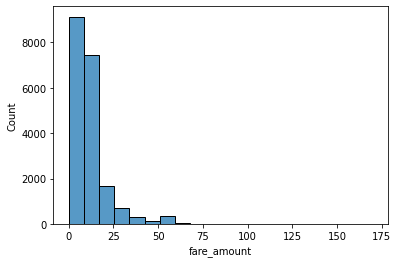

In [10]:
sns.histplot(df['fare_amount'],kde=False,bins=20)

- The histogram is really skewed as we can see.

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fare_amount'>

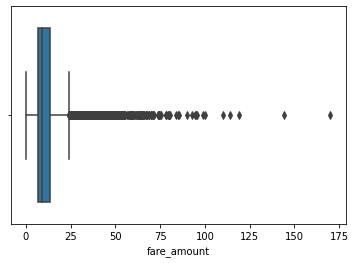

In [11]:
sns.boxplot(df['fare_amount'])

- not many outliers

In [12]:
df['fare_amount'].sort_values(ascending=False)

46951     170.00
62463     144.00
175118    119.00
80935     114.00
76285     110.00
           ...  
79486       2.50
132695      2.50
101995      2.50
77124       2.50
147847      0.01
Name: fare_amount, Length: 19781, dtype: float64

#### Vendor Id

<AxesSubplot:xlabel='VendorID', ylabel='count'>

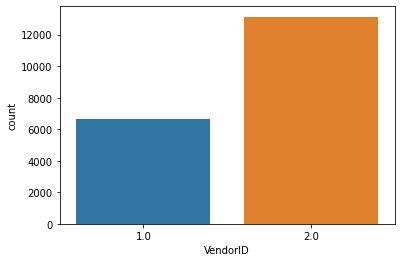

In [13]:
sns.countplot(x='VendorID',data=df)

- we can see there is significant difference between these two vendors trip vcount

#### Passenger Count

In [14]:
df.passenger_count.value_counts()

1    14585
2     2723
3      759
5      598
0      430
6      399
4      287
Name: passenger_count, dtype: int64

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

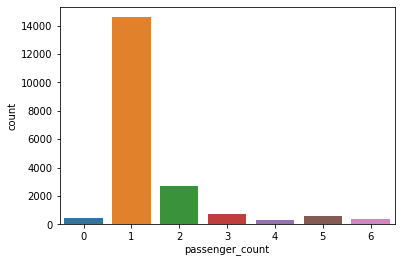

In [15]:
sns.countplot(x='passenger_count',data=df)

- the highest amount of trips are with 1 passenger.

#### Store and Forward Flag

In [16]:
df['store_and_fwd_flag'].value_counts(normalize=True)

N    0.988676
Y    0.011324
Name: store_and_fwd_flag, dtype: float64

- We see there are only 1% of trips that were stored before forwarding.

#### Distance

In [17]:
df['trip_distance'].value_counts()

1.022828    304
0.329383    139
1.010691    132
0.447913    128
0.699858    116
           ... 
7.501683      1
7.429666      1
2.917650      1
4.642781      1
8.901694      1
Name: trip_distance, Length: 2722, dtype: int64

- The reasons for 0 km distance can be:
     - The dropoff location couldn’t be tracked.
     - The driver deliberately took this ride to complete a target ride number.
     - The passengers canceled the trip.

### Trips per day

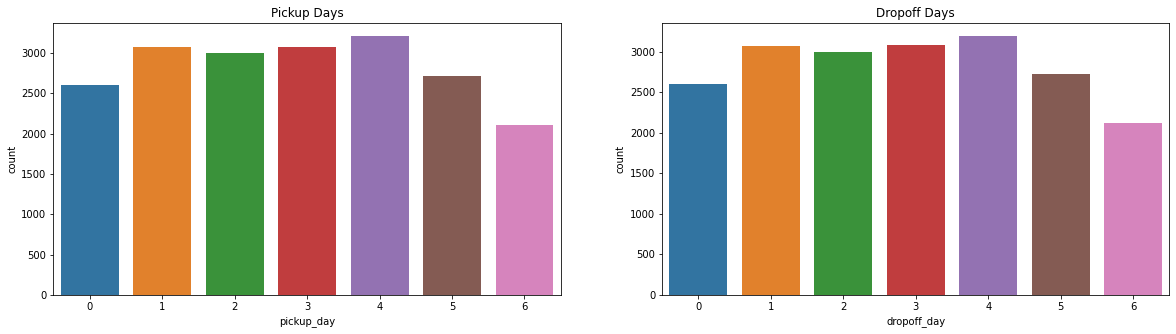

In [18]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))

ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=df,ax=ax1)

ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=df,ax=ax2)

- We see Fridays are the busiest days followed by Saturdays. That is probably because it’s weekend.

### trips per hour

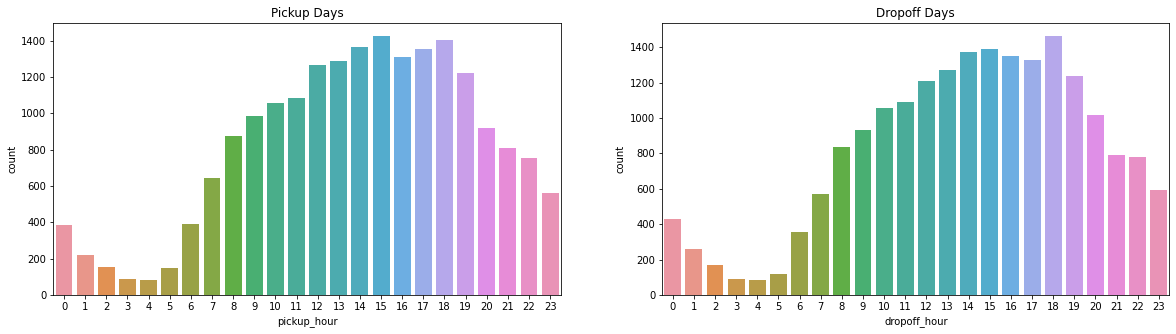

In [19]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))

ax9.set_title('Pickup Days')
ax=sns.countplot(x="pickup_hour",data=df,ax=ax9)

ax10.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_hour",data=df,ax=ax10)

- We see the busiest hours are 6:00 pm to 7:00 pm and that makes sense as this is the time when people return from their offices.

### Trips per Time of Day

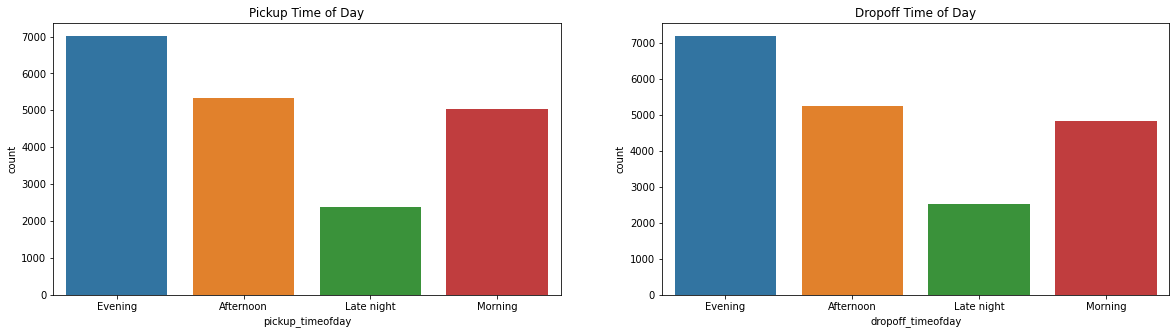

In [20]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))

ax3.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=df,ax=ax3)

ax4.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=df,ax=ax4)

- As we saw above, evenings are the busiest.

### trips per month

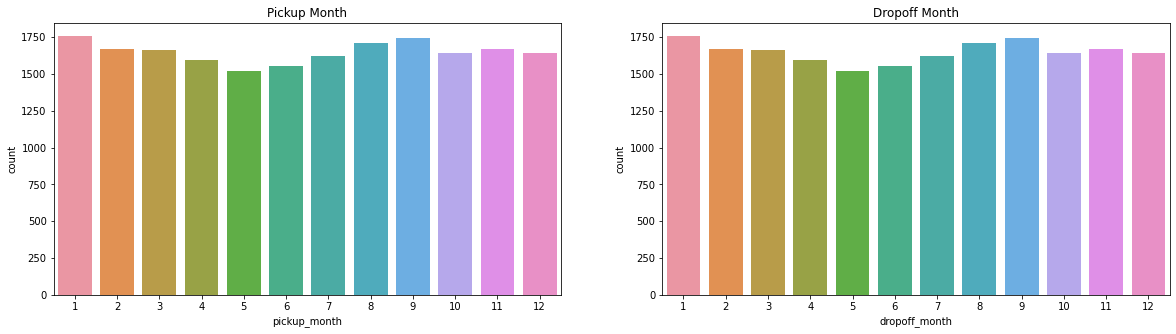

In [21]:
figure,(ax11,ax12)=plt.subplots(ncols=2,figsize=(20,5))
ax11.set_title('Pickup Month')
ax=sns.countplot(x="pickup_month",data=df,ax=ax11)
ax12.set_title('Dropoff Month')
ax=sns.countplot(x="dropoff_month",data=df,ax=ax12)

- There is not much difference in the number of trips across months.

### Bivariate Analysis

- Bivariate Analysis involves finding relationships, patterns, and correlations between two variables.

### Trip Duration per Vendor

<AxesSubplot:xlabel='VendorID', ylabel='fare_amount'>

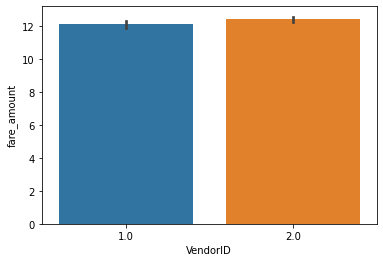

In [22]:
# sns.barplot(y='trip_duration',x='VendorID',data=df,estimator=np.mean)
sns.barplot(y='fare_amount',x='VendorID',data=df,estimator=np.mean)

- Vendor id 2 takes longer trips as compared to vendor 1.

### Trip Duration per Store and Forward Flag

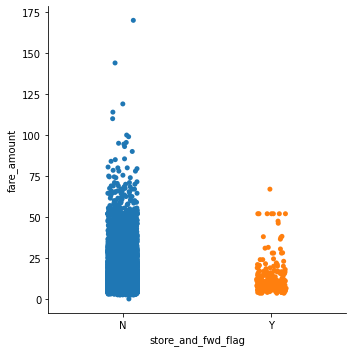

In [23]:
# sns.catplot(y='trip_duration',x='store_and_fwd_flag',data=df,kind="strip")
sns.catplot(y='fare_amount',x='store_and_fwd_flag',data=df,kind="strip")

- Trip duration is generally longer for trips whose flag was not stored

### Trip Duration per passenger count

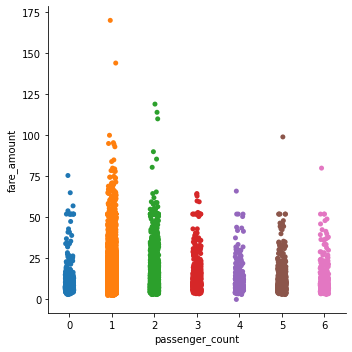

In [24]:
# sns.catplot(y='trip_duration',x='passenger_count',data=df,kind="strip")
sns.catplot(y='fare_amount',x='passenger_count',data=df,kind="strip")

- There is no visible relation between trip duration and passenger count.

### Trip Duration per hour

<AxesSubplot:xlabel='pickup_hour', ylabel='fare_amount'>

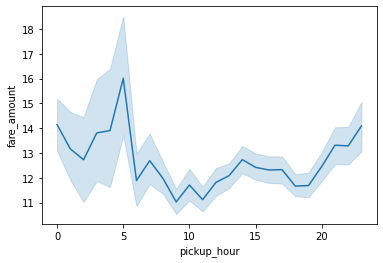

In [25]:
# sns.lineplot(x='pickup_hour',y='trip_duration',data=df)
sns.lineplot(x='pickup_hour',y='fare_amount',data=df)

- We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.

- Trip duration is the lowest around 6 am as streets may not be busy.

### Trip duration per time of day

<AxesSubplot:xlabel='pickup_timeofday', ylabel='fare_amount'>

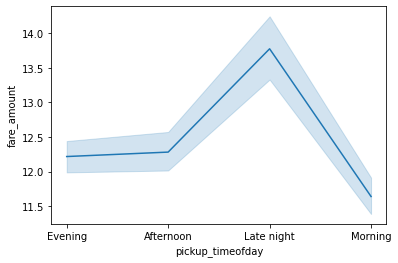

In [26]:
# sns.lineplot(x='pickup_timeofday',y='trip_duration',data=df)
sns.lineplot(x='pickup_timeofday',y='fare_amount',data=df)

- As we saw above, trip duration is the maximum in the afternoon and lowest between late night and morning.

### Trip duration per Day of Week

<AxesSubplot:xlabel='pickup_day_no', ylabel='fare_amount'>

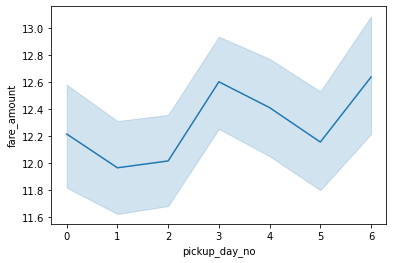

In [27]:
# sns.lineplot(x='pickup_day_no',y='trip_duration',data=df)
sns.lineplot(x='pickup_day_no',y='fare_amount',data=df)

- Trip duration is the longest on Thursdays closely followed by Fridays

### Trip duration per month

<AxesSubplot:xlabel='pickup_month', ylabel='fare_amount'>

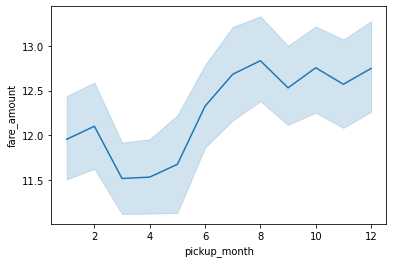

In [28]:
# sns.lineplot(x='pickup_month',y='trip_duration',data=df)
sns.lineplot(x='pickup_month',y='fare_amount',data=df)

- From February, we can see trip duration rising every month.

### Data Visualization

The next step is to get insight to data.

Remove any noisy or outlier data and understand data distribution

In [29]:
df.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'PU_zone', 'PU_borough', 'pickup_latitude',
       'pickup_longitude', 'DO_zone', 'DO_borough', 'dropoff_latitude',
       'dropoff_longitude', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_year', 'dropoff_year', 'trip_duration',
       'pickup_timeofday', 'dropoff_timeofday', 'mid_night_trip',
       'rush_hour_trip', 'snow_season', 'distance_lib', 'haversine_distance',
       'pickup_manhattan', 'pickup_jfk', 'pickup_brooklyn', 'pickup_bronx',
       'pickup_laGuardia', 'drop_manhattan', 'drop_jfk', 'drop_brooklyn',
       'drop_bronx', 'drop_laGuardia

#### distance travelled by hour by days

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


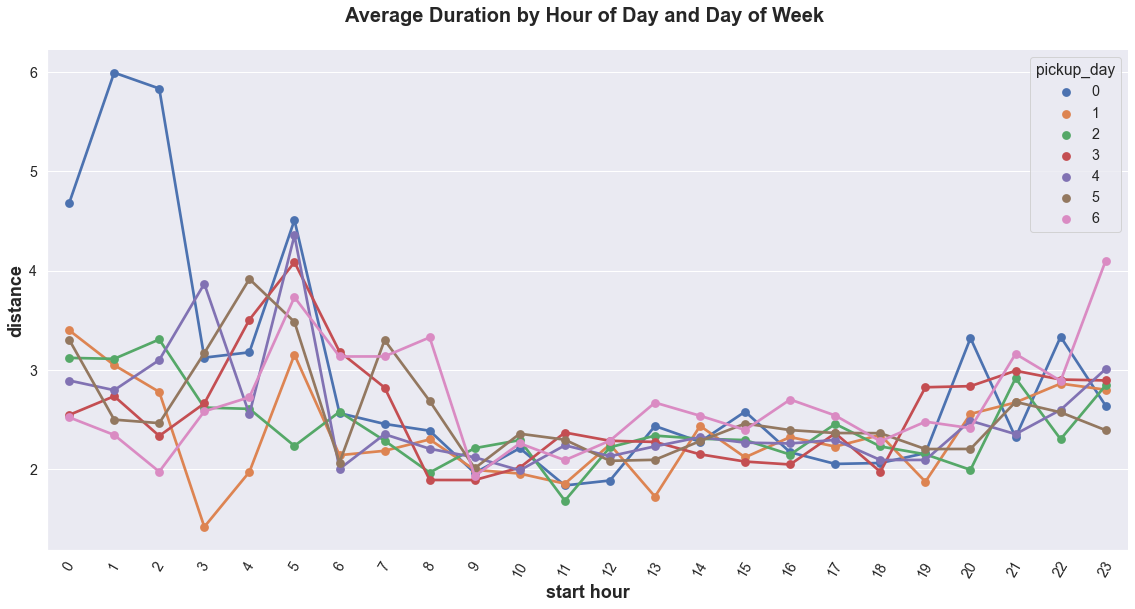

In [30]:
sns.set(font_scale=1.3)
g = sns.factorplot('pickup_hour', 
                   'haversine_distance', 
                   hue = 'pickup_day', 
                   estimator = np.mean, 
                   data = df, 
                   size = 8, 
                   aspect = 2, 
                    ci=None,
                   legend_out=False)
plt.title('Average Duration by Hour of Day and Day of Week \n',weight='bold', size = 20)
plt.xlabel('start hour', size = 18,weight = 'bold')
plt.ylabel('distance', size = 18,weight = 'bold')
g.set_xticklabels(rotation=60)

####  count of trip per year, per month, per weekdays, per hour

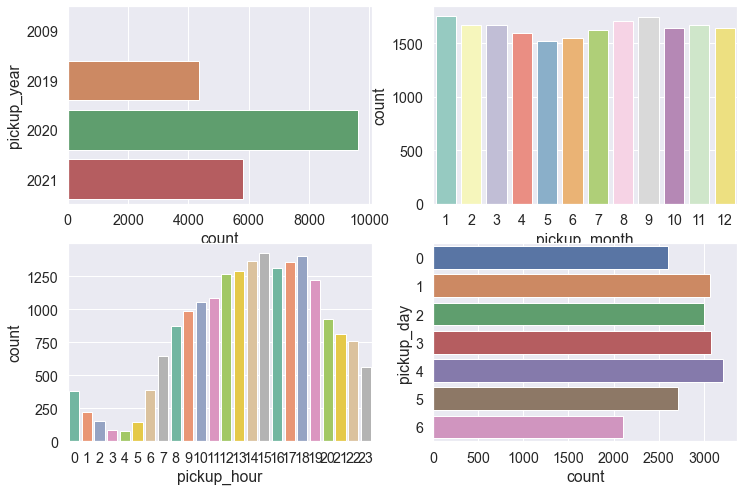

In [31]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.countplot(y='pickup_year', data=df)
plt.subplot(2,2,2)
sns.countplot(x='pickup_month', data=df,palette='Set3')
plt.subplot(2,2,3)
sns.countplot(x='pickup_hour', data=df,palette='Set2')
plt.subplot(2,2,4)
sns.countplot(y='pickup_day', data=df)

plt.show()

####  count as per mid night trip, per rush hour trip, per passenger count, per snow season

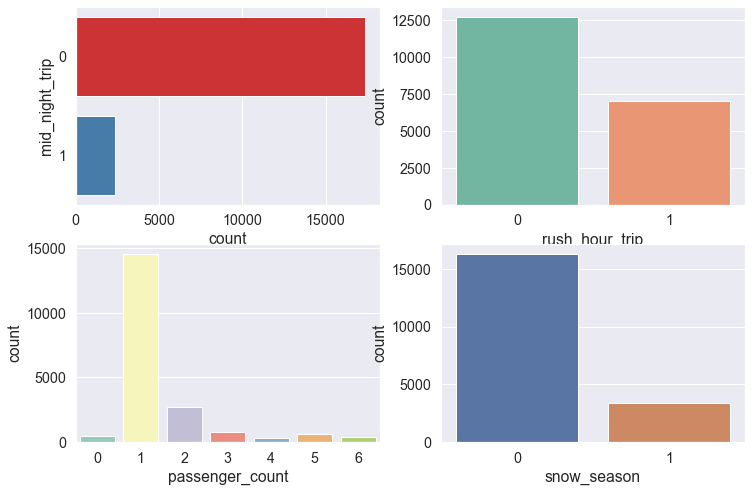

In [32]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.countplot(y='mid_night_trip', data=df,palette='Set1')

plt.subplot(2,2,2)
sns.countplot(x='rush_hour_trip', data=df,palette='Set2')

plt.subplot(2,2,3)
sns.countplot(x='passenger_count', data=df,palette='Set3')

plt.subplot(2,2,4)
sns.countplot(x='snow_season', data=df)

plt.show()

####  count as per pick weekday and as per airport trip

<AxesSubplot:xlabel='isAirportTrip', ylabel='count'>

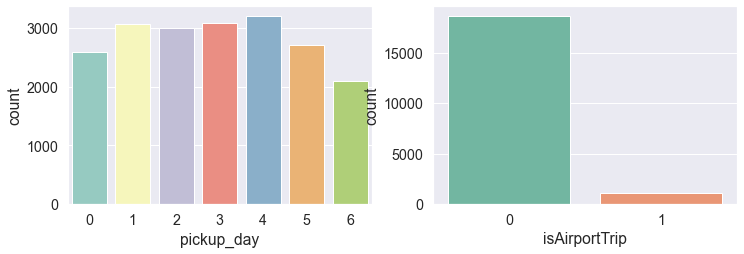

In [33]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.countplot(x='pickup_day',data=df,palette='Set3')

plt.subplot(2,2,2)
sns.countplot(x='isAirportTrip',data=df,palette='Set2')

####  Pickup Location Count Plot as per region

<AxesSubplot:xlabel='pickup_laGuardia', ylabel='count'>

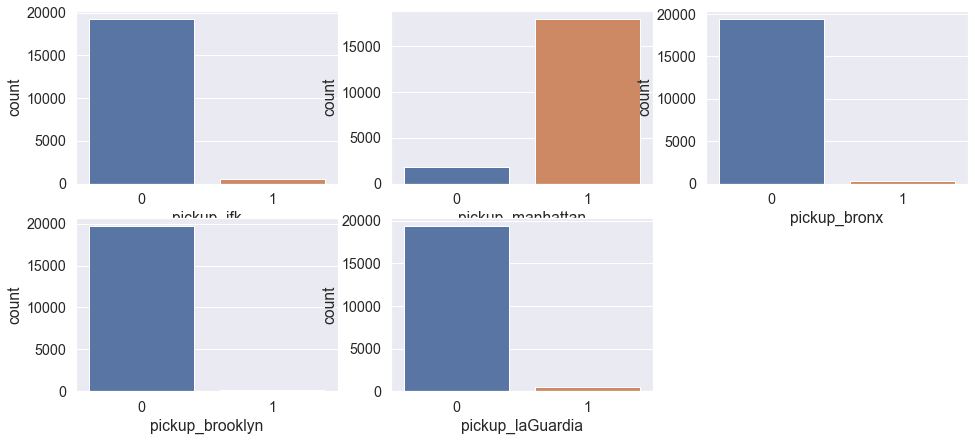

In [34]:
plt.figure(figsize=(16,7))
plt.subplot(2,3,1)
sns.countplot(x='pickup_jfk',data=df)
plt.subplot(2,3,2)
sns.countplot(x='pickup_manhattan',data=df)
plt.subplot(2,3,3)
sns.countplot(x='pickup_bronx',data=df)
plt.subplot(2,3,4)
sns.countplot(x='pickup_brooklyn',data=df)
plt.subplot(2,3,5)
sns.countplot(x='pickup_laGuardia',data=df)
# plt.show()

####  Drop Location Count Plot as per region

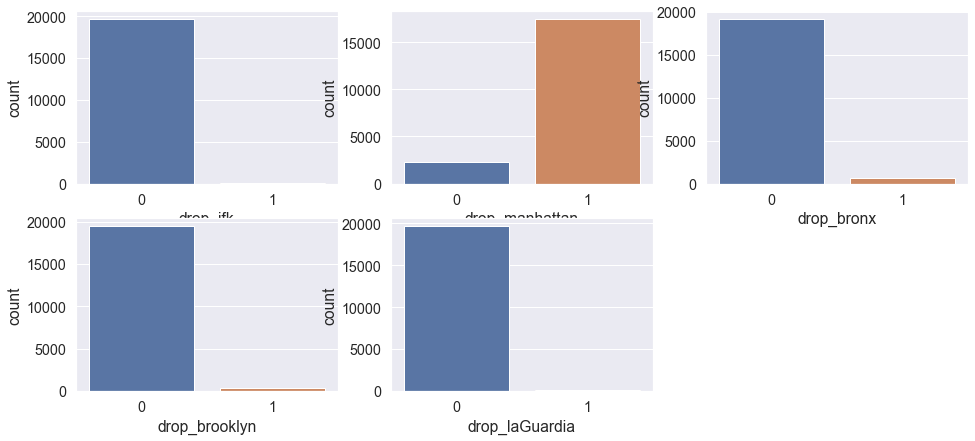

In [35]:
plt.figure(figsize=(16,7))
plt.subplot(2,3,1)
sns.countplot(x='drop_jfk',data=df)
plt.subplot(2,3,2)
sns.countplot(x='drop_manhattan',data=df)
plt.subplot(2,3,3)
sns.countplot(x='drop_bronx',data=df)
plt.subplot(2,3,4)
sns.countplot(x='drop_brooklyn',data=df)
plt.subplot(2,3,5)
sns.countplot(x='drop_laGuardia',data=df)
plt.show()

####  Fare amount vs Trip distance

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array w

<AxesSubplot:xlabel='fare_amount', ylabel='trip_distance'>

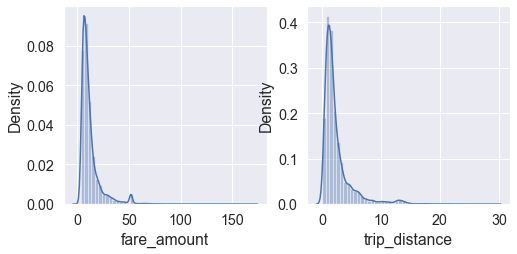

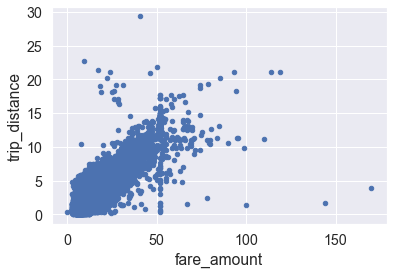

In [36]:
plt.figure(figsize=(8,8))

# fare amount density
plt.subplot(2,2,1)
sns.distplot(df['fare_amount'],kde=True)

# trip distance density 
plt.subplot(2,2,2)
sns.distplot(df['trip_distance'],kde=True)

# fare amount vs trip distance
df.plot(x='fare_amount',y='trip_distance',kind='scatter')

####  cancel ride desnity

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

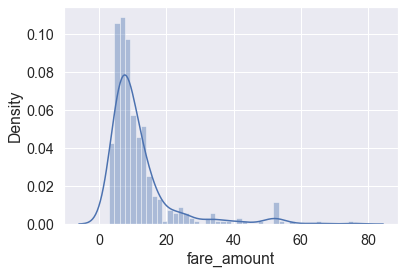

In [37]:
cancel_ride=df[(df['fare_amount']>=0) & (df['passenger_count']==0)]
sns.distplot(cancel_ride['fare_amount'],kde=True)

####  log of fare amount vs density 

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

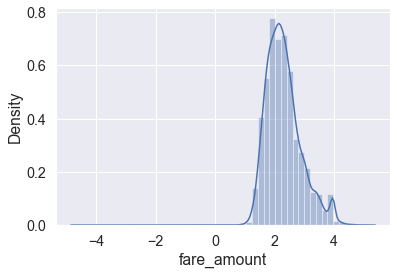

In [38]:
sns.distplot(np.log(df['fare_amount']),kde=True)

####  Airport vs Non Aiport Trip Fare Distributinon

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


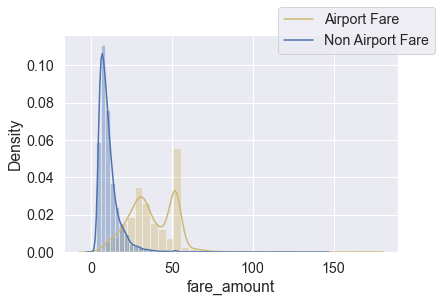

In [39]:
df_airport=df[df['isAirportTrip']==1]
df_non_airport=df[df['isAirportTrip']==0]

fig = plt.figure(figsize=(6,4))
sns.distplot(df_airport['fare_amount'],kde=True,color="y")
sns.distplot(df_non_airport['fare_amount'],kde=True)
fig.legend(labels=['Airport Fare','Non Airport Fare'])
plt.show()

####  Different Area Fare Distribution

In [40]:
df_manhattan=df[(df['pickup_manhattan']==1) | (df['drop_manhattan']==1)]
df_jfk=df[(df['pickup_jfk']==1) | (df['drop_jfk']==1)]
df_bronx=df[(df['pickup_bronx']==1) | (df['drop_bronx']==1)]
df_brooklyn=df[(df['pickup_brooklyn']==1) | (df['drop_brooklyn']==1)]
df_LGD=df[(df['pickup_laGuardia']==1) | (df['drop_laGuardia']==1)]

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

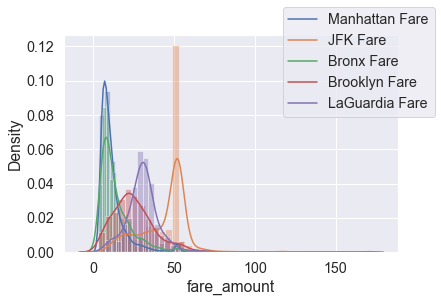

In [41]:
fig = plt.figure(figsize=(6,4))

sns.distplot(df_manhattan['fare_amount'],kde=True)
sns.distplot(df_jfk['fare_amount'],kde=True)
sns.distplot(df_bronx['fare_amount'],kde=True)
sns.distplot(df_brooklyn['fare_amount'],kde=True)
sns.distplot(df_LGD['fare_amount'],kde=True)
fig.legend(labels=['Manhattan Fare','JFK Fare','Bronx Fare','Brooklyn Fare','LaGuardia Fare'])
plt.show()

####  Fare Distribution of Manhattan

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

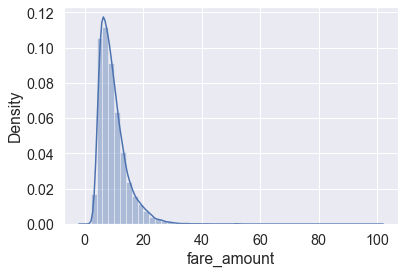

In [42]:
df_man=df[ (df['pickup_manhattan'] ==1) & (df['drop_manhattan'] ==1)]
sns.distplot(df_man['fare_amount'],kde=True)

In [43]:
df_man['fare_amount'].sum()/df_man.shape[0]
df=df[~((df['pickup_manhattan'] ==1) & (df['drop_manhattan'] ==1) & (df['fare_amount'] > 20))]

####  Fare Distribution at Different Time Zone

C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\onkar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

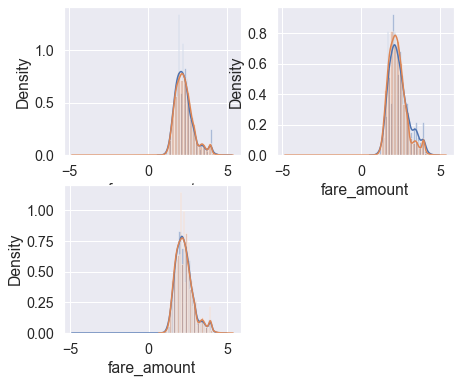

In [44]:
df_snow=df[df['snow_season']==1]
df_non_snow=df[df['snow_season']==0]

fig = plt.figure(figsize=(7,6))
ax=plt.subplot(2,2,1)
sns.distplot(np.log(df_snow['fare_amount']),ax=ax)
sns.distplot(np.log(df_non_snow['fare_amount']),ax=ax)


df_mid=df[df['mid_night_trip']==1]
df_non_mid=df[df['mid_night_trip']==0]
ax=plt.subplot(2,2,2)
sns.distplot(np.log(df_mid['fare_amount']),ax=ax)
sns.distplot(np.log(df_non_mid['fare_amount']),ax=ax)

df_rush_hour=df[df['rush_hour_trip']==1]
df_non_rush_hour=df[df['rush_hour_trip']==0]
ax=plt.subplot(2,2,3)
sns.distplot(np.log(df_rush_hour['fare_amount']),ax=ax)
sns.distplot(np.log(df_non_rush_hour['fare_amount']),ax=ax)

### Correlation

- corr() is used for correlation

In [45]:
df.corr()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,pickup_jfk,pickup_brooklyn,pickup_bronx,pickup_laGuardia,drop_manhattan,drop_jfk,drop_brooklyn,drop_bronx,drop_laGuardia,isAirportTrip
VendorID,1.000000,0.192211,0.005346,0.020678,0.006710,0.009573,-0.036358,0.014758,-0.866841,0.006534,...,0.019932,-0.003919,-0.024095,-0.000440,0.006878,0.003549,0.006051,-0.015254,0.004751,0.016292
passenger_count,0.192211,1.000000,-0.010588,0.000168,-0.002571,0.002254,0.004154,-0.002254,-0.162162,0.005794,...,-0.000176,-0.014852,-0.019523,0.007064,0.011633,-0.000385,-0.004279,-0.009022,0.006052,0.007902
trip_distance,0.005346,-0.010588,1.000000,0.432742,-0.066673,-0.084302,-0.003826,0.862409,-0.018338,-0.139643,...,0.545061,0.028719,0.042450,0.236214,-0.523110,0.268082,0.160329,0.126590,0.132382,0.631590
RatecodeID,0.020678,0.000168,0.432742,1.000000,-0.036070,-0.052227,-0.008870,0.515991,-0.010672,-0.538408,...,0.327611,-0.008102,-0.015952,-0.004535,-0.111209,0.284476,-0.015622,-0.009558,0.012723,0.308677
PULocationID,0.006710,-0.002571,-0.066673,-0.036070,1.000000,0.030832,-0.050254,-0.089176,0.032103,0.007529,...,-0.069657,-0.080255,-0.157952,-0.063463,0.061840,-0.003732,-0.025322,-0.014872,0.000287,-0.085147
DOLocationID,0.009573,0.002254,-0.084302,-0.052227,0.030832,1.000000,-0.054202,-0.124947,0.017928,0.069097,...,-0.055725,-0.035860,-0.022290,-0.034488,0.175950,-0.015129,-0.128858,-0.154830,-0.028242,-0.073198
payment_type,-0.036358,0.004154,-0.003826,-0.008870,-0.050254,-0.054202,1.000000,-0.010716,-0.002110,0.000061,...,0.049684,0.004740,0.043311,0.001428,-0.068722,-0.013694,-0.002198,0.054395,-0.016279,0.021748
fare_amount,0.014758,-0.002254,0.862409,0.515991,-0.089176,-0.124947,-0.010716,1.000000,-0.026914,-0.252223,...,0.514051,0.027052,0.006094,0.269835,-0.459701,0.248892,0.184058,0.056185,0.183558,0.648237
extra,-0.866841,-0.162162,-0.018338,-0.010672,0.032103,0.017928,-0.002110,-0.026914,1.000000,0.029389,...,-0.022962,-0.032024,-0.032464,-0.027312,0.067583,-0.014199,-0.019035,-0.028275,-0.019560,-0.039922
mta_tax,0.006534,0.005794,-0.139643,-0.538408,0.007529,0.069097,0.000061,-0.252223,0.029389,1.000000,...,-0.015208,0.003737,0.007358,0.008197,0.107897,-0.024044,0.007205,0.009642,-0.017870,-0.019149


- heatmap to look for variable dependencies

<AxesSubplot:>

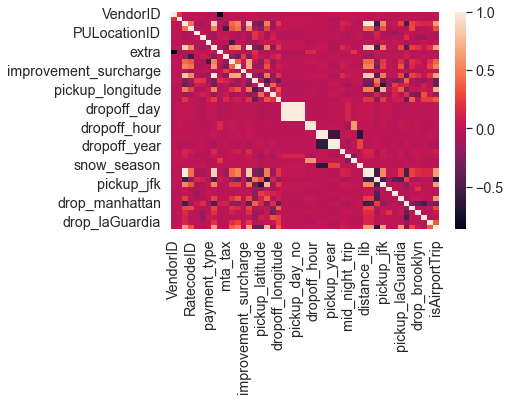

In [46]:
sns.heatmap(df.corr())

- shows all columns

In [47]:
df.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'PU_zone', 'PU_borough', 'pickup_latitude',
       'pickup_longitude', 'DO_zone', 'DO_borough', 'dropoff_latitude',
       'dropoff_longitude', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_year', 'dropoff_year', 'trip_duration',
       'pickup_timeofday', 'dropoff_timeofday', 'mid_night_trip',
       'rush_hour_trip', 'snow_season', 'distance_lib', 'haversine_distance',
       'pickup_manhattan', 'pickup_jfk', 'pickup_brooklyn', 'pickup_bronx',
       'pickup_laGuardia', 'drop_manhattan', 'drop_jfk', 'drop_brooklyn',
       'drop_bronx', 'drop_laGuardia

- show number of records and number of columns 

In [48]:
df.shape

(19176, 55)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19176 entries, 23516 to 172759
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               19176 non-null  float64
 1   pickup_datetime        19176 non-null  object 
 2   dropoff_datetime       19176 non-null  object 
 3   passenger_count        19176 non-null  int64  
 4   trip_distance          19176 non-null  float64
 5   RatecodeID             19176 non-null  float64
 6   store_and_fwd_flag     19176 non-null  object 
 7   PULocationID           19176 non-null  int64  
 8   DOLocationID           19176 non-null  int64  
 9   payment_type           19176 non-null  float64
 10  fare_amount            19176 non-null  float64
 11  extra                  19176 non-null  float64
 12  mta_tax                19176 non-null  float64
 13  tip_amount             19176 non-null  float64
 14  tolls_amount           19176 non-null  float64
 1

### PCA

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Profit is the dependent column
y = df['total_amount']

# start with nothing
x_names = []

# the previous r2
previous_r2 = -1

# list of all columns
columns = ['VendorID', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_year', 'dropoff_year', 'trip_duration',
       'mid_night_trip',
       'rush_hour_trip', 'snow_season', 'distance_lib', 'haversine_distance',
       'pickup_manhattan', 'pickup_jfk', 'pickup_brooklyn', 'pickup_bronx',
       'pickup_laGuardia', 'drop_manhattan', 'drop_jfk', 'drop_brooklyn',
       'drop_bronx', 'drop_laGuardia', 'isAirportTrip']

# choose one col at a time and check its significance
for col in columns:
    
    # this will hold all the variables need to pass to the model
    temp_variables = []
    
    # add previously selected variable(s)
    temp_variables.extend(x_names)
    
    # add the current column
    temp_variables.append(col)
    
    print(f"selected columns {temp_variables}")
    
    # get all the variables in the form of a df
    x = df[temp_variables]
    
    # create model 
    model = LinearRegression()
    
    # train the model
    model.fit(x, y)
    
    # predict the values
    predictions = model.predict(x)
    
    # evaluate the model
    r2 = r2_score(y, predictions)

    print(f"previous r2 = {previous_r2}, current r2 = {r2}")
    
    # check if this is the first variable
    if previous_r2 == -1:
        previous_r2 = r2
        x_names.append(col)
        print(rf"since this is the first column, add ({col}) it to the list")
    else:
        # check if this r2 is greater than the previous one
        # if r2 > previous_r2:
        
        # check if the r2 difference is significant
        print(f"r2 - previous_r2 = {r2 - previous_r2}")
        if (r2 - previous_r2) >= 0.03:
            previous_r2 = r2
            x_names.append(col)
            print(f"found col: {col} increasing the r2 score")
        
        
print(f"finally selected columns = {x_names}")

selected columns ['VendorID']
previous r2 = -1, current r2 = 0.00046026856507619396
since this is the first column, add (VendorID) it to the list
selected columns ['VendorID', 'passenger_count']
previous r2 = 0.00046026856507619396, current r2 = 0.0004758577277516052
r2 - previous_r2 = 1.5589162675411217e-05
selected columns ['VendorID', 'trip_distance']
previous r2 = 0.00046026856507619396, current r2 = 0.6940967959627
r2 - previous_r2 = 0.6936365273976238
found col: trip_distance increasing the r2 score
selected columns ['VendorID', 'trip_distance', 'RatecodeID']
previous r2 = 0.6940967959627, current r2 = 0.7318991284234294
r2 - previous_r2 = 0.03780233246072939
found col: RatecodeID increasing the r2 score
selected columns ['VendorID', 'trip_distance', 'RatecodeID', 'PULocationID']
previous r2 = 0.7318991284234294, current r2 = 0.7320466773762722
r2 - previous_r2 = 0.0001475489528427465
selected columns ['VendorID', 'trip_distance', 'RatecodeID', 'DOLocationID']
previous r2 = 0.731

In [51]:
## finally selected columns = ['VendorID', 'trip_distance', 'RatecodeID', 'payment_type', 'fare_amount', 'tip_amount'] --- 0.01

### Separate the independent and dependent relationship

- independent variables

In [52]:
df.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'PU_zone', 'PU_borough', 'pickup_latitude',
       'pickup_longitude', 'DO_zone', 'DO_borough', 'dropoff_latitude',
       'dropoff_longitude', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_year', 'dropoff_year', 'trip_duration',
       'pickup_timeofday', 'dropoff_timeofday', 'mid_night_trip',
       'rush_hour_trip', 'snow_season', 'distance_lib', 'haversine_distance',
       'pickup_manhattan', 'pickup_jfk', 'pickup_brooklyn', 'pickup_bronx',
       'pickup_laGuardia', 'drop_manhattan', 'drop_jfk', 'drop_brooklyn',
       'drop_bronx', 'drop_laGuardia

In [53]:
x = df.drop(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'PU_zone', 'PU_borough', 'pickup_latitude',
       'pickup_longitude', 'DO_zone', 'DO_borough', 'dropoff_latitude',
       'dropoff_longitude', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_year', 'dropoff_year', 'trip_duration',
       'pickup_timeofday', 'dropoff_timeofday', 'mid_night_trip',
       'rush_hour_trip', 'snow_season', 'distance_lib', 'haversine_distance',
       'pickup_manhattan', 'pickup_jfk', 'pickup_brooklyn', 'pickup_bronx',
       'pickup_laGuardia', 'drop_manhattan', 'drop_jfk', 'drop_brooklyn',
       'drop_bronx', 'drop_laGuardia', 'isAirportTrip'], axis=1).values

- dependent variable

In [54]:
y1 = df['total_amount']

In [55]:
y2 = df['fare_amount']

In [56]:
y3 = df['tip_amount']

## LINEAR REGRESSION

#### Split the data into train and tests sets

In [57]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train1,y_test1 = train_test_split(x,y1,train_size=0.8,test_size=0.2,random_state=864)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train2,y_test2 = train_test_split(x,y2,train_size=0.8,test_size=0.2,random_state=864)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train3,y_test3 = train_test_split(x,y3,train_size=0.8,test_size=0.2,random_state=864)

### Import linear regression algorithm from scikit

In [58]:
from sklearn.linear_model import LinearRegression
# creating model using LinearRegression algorithm
model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

### Creating Model

In [59]:
# creating model 
model1.fit(x_train,y_train1)
model2.fit(x_train,y_train2)
model3.fit(x_train,y_train3)

LinearRegression()

### Testing the model

In [60]:
# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model1.predict(x_test)

# r2_score
print(f"r2_score : {r2_score(y_test1,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test1,predictions)}")
print(f"mean squared error : {mean_squared_error(y_test1,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test1,predictions))}")

# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model2.predict(x_test)

# r2_score
print(f"r2_score : {r2_score(y_test2,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test2,predictions)}")
print(f"mean squared error : {mean_squared_error(y_test2,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test2,predictions))}")

# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model3.predict(x_test)

# r2_score
print(f"r2_score : {r2_score(y_test3,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test3,predictions)}")
print(f"mean squared error : {mean_squared_error(y_test3,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test3,predictions))}")

r2_score : 0.7124840521993461
mean absolute error : 3.9859334747109543
mean squared error : 42.0581555557264
root mean squared error : 6.485225944847751
r2_score : 0.768058829125663
mean absolute error : 2.946900209292778
mean squared error : 21.68779982112388
root mean squared error : 4.657016192920514
r2_score : 0.18026531721712669
mean absolute error : 1.4856297129432792
mean squared error : 4.5863744030421
root mean squared error : 2.1415822195381855


## XG Boost

#### SPlitting the dataset into training and testing sets

In [61]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train1,y_test1 = train_test_split(x,y1,train_size=0.8,test_size=0.2,random_state=563)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train2,y_test2 = train_test_split(x,y2,train_size=0.8,test_size=0.2,random_state=563)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train3,y_test3 = train_test_split(x,y3,train_size=0.8,test_size=0.2,random_state=563)

#### Importing XGBoost algorithm from scikit

In [62]:
from xgboost import XGBRegressor
# creating model using LinearRegression algorithm
model_21 = XGBRegressor()
model_22 = XGBRegressor()
model_23 = XGBRegressor()

In [63]:
# model_2.get_params()

In [64]:
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ], #so called `eta` value
#               'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
#               'gamma' : [0.0, 0.1, 0.2 , 0.3, 0.4],
#               'eta':[.03], 
#               'eval_metric':['rmse'],
#               'min_child_weight': [1, 3, 5, 7],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.3, 0.4, 0.5 , 0.7],
#               'n_estimators': [786]}

# paramters = {
#      "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
#      "min_child_weight" : [ 1, 3, 5, 7 ],
#      "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#      "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
# }

In [65]:
# from sklearn.model_selection import GridSearchCV

In [66]:
# xgb_grid = GridSearchCV(model_2,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

#### Creating the model

In [67]:
# creating model 
model_21.fit(x_train,y_train1)

# creating model 
model_22.fit(x_train,y_train2)

# creating model 
model_23.fit(x_train,y_train3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [68]:
# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

#### Testing the model

In [69]:
# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model_21.predict(x_test)

# r2_score
print(f"r2_score : {r2_score(y_test1,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test1,predictions)}")
print(f"mean squared error : {mean_squared_error(y_test1,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test1,predictions))}")

# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model_22.predict(x_test)

# r2_score
print(f"r2_score : {r2_score(y_test2,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test2,predictions)}")
print(f"mean squared error : {mean_squared_error(y_test2,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test2,predictions))}")

# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model_23.predict(x_test)

# r2_score
print(f"r2_score : {r2_score(y_test3,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test3,predictions)}")
print(f"mean squared error : {mean_squared_error(y_test3,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test3,predictions))}")

r2_score : 0.6859028499784019
mean absolute error : 3.2117854464414592
mean squared error : 47.78409764030282
root mean squared error : 6.9126042589101555
r2_score : 0.7523146875638542
mean absolute error : 2.3505410443008627
mean squared error : 24.214923364252822
root mean squared error : 4.920866119318105
r2_score : 0.08572907843765121
mean absolute error : 1.4579894734605199
mean squared error : 6.813635443186579
root mean squared error : 2.6102941296310993


## RANDOM FOREST

#### Splitting the dataset into training and testing sets

In [70]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train1,y_test1 = train_test_split(x,y1,train_size=0.8,test_size=0.2,random_state=563)
# 563

from sklearn.model_selection import train_test_split
x_train,x_test,y_train2,y_test2 = train_test_split(x,y2,train_size=0.8,test_size=0.2,random_state=563)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train3,y_test3 = train_test_split(x,y3,train_size=0.8,test_size=0.2,random_state=563)

#### Importing random forest algorithm from scikit

In [71]:
from sklearn.ensemble import RandomForestRegressor
# creating model using Random Forest algorithm
model_31 = RandomForestRegressor()

model_32 = RandomForestRegressor()

model_33 = RandomForestRegressor()

In [72]:
# model_3.get_params()

In [73]:
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

In [74]:
# param_grid = { 
#     'n_estimators': [300, 500, 700],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
# }

In [75]:
# from sklearn.model_selection import GridSearchCV

In [76]:
# rf_grid = GridSearchCV(model_3,
#                         param_grid,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

#### creating the model

In [77]:
# creating model 
model_31.fit(x_train,y_train1)

# creating model 
model_32.fit(x_train,y_train2)

# creating model 
model_33.fit(x_train,y_train3)

RandomForestRegressor()

### Testing the model

In [78]:
# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model_31.predict(x_test)

# r2_score
print(f"r2_score            : {r2_score(y_test1,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test1,predictions)}")
print(f"mean squared error  : {mean_squared_error(y_test1,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test1,predictions))}")

# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model_32.predict(x_test)

# r2_score
print(f"r2_score            : {r2_score(y_test2,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test2,predictions)}")
print(f"mean squared error  : {mean_squared_error(y_test2,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test2,predictions))}")

# importing libraries from sklearn
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# storing predicted values in predictions
predictions=model_33.predict(x_test)

# r2_score
print(f"r2_score            : {r2_score(y_test3,predictions)}")
print(f"mean absolute error : {mean_absolute_error(y_test3,predictions)}")
print(f"mean squared error  : {mean_squared_error(y_test3,predictions)}")
print(f"root mean squared error : {np.sqrt(mean_squared_error(y_test3,predictions))}")

r2_score            : 0.6912343382498818
mean absolute error : 3.126620397962295
mean squared error  : 46.97300987298304
root mean squared error : 6.853685860395342
r2_score            : 0.7543850836713372
mean absolute error : 2.260250042613174
mean squared error  : 24.012511349655572
root mean squared error : 4.90025625346834
r2_score            : 0.043324071465476566
mean absolute error : 1.4919538544022795
mean squared error  : 7.129660214028511
root mean squared error : 2.6701423583825097


In [79]:
value=np.array([2.        , 1.02282796 ])

In [80]:
value

array([2.        , 1.02282796])

In [81]:
model_31.predict([value])

array([11.74965742])

In [82]:
model_32.predict([value])

array([6.67600539])

In [83]:
model_33.predict([value])

array([1.48235196])

In [84]:
import pickle

# create the file to store the model
# w: write
# b: binary data
file1 = open('taxi_fare_RANDOM1.pkl', 'wb')

# store the model using pickle
pickle.dump(model_31, file1)

# save the file
file1.close()

# create the file to store the model
# w: write
# b: binary data
file2 = open('taxi_fare_RANDOM2.pkl', 'wb')

# store the model using pickle
pickle.dump(model_32, file2)

# save the file
file2.close()

# create the file to store the model
# w: write
# b: binary data
file3 = open('taxi_fare_RANDOM3.pkl', 'wb')

# store the model using pickle
pickle.dump(model_33, file3)

# save the file
file3.close()